In [13]:
# import packages
import numpy as np
import pandas as pd

import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import plotly.express as px


# use sklearn for linear regression
from sklearn.linear_model import LinearRegression

In [3]:
# gather data from yahoo
# will use the SPY for the market and will compare Causeway Capital Funds vs Vanguard

# define start and end dates
end_date = datetime.date(2024,1,1)
start_date = end_date - pd.Timedelta(days=365*5)

#Vanguard vs Causeway Global Value Fund

SPY_df = yf.download("SPY",start=start_date,end=end_date,progress=False)
VGPMX_df = yf.download("VGPMX",start=start_date,end=end_date,progress=False)
CGVVX_df = yf.download("CGVVX",start=start_date,end=end_date,progress=False)

#compute log returns
SPY_df['SPY'] = np.log(SPY_df['Adj Close']/SPY_df['Adj Close'].shift(1))
VGPMX_df['VGPMX'] = np.log(VGPMX_df['Adj Close']/VGPMX_df['Adj Close'].shift(1))
CGVVX_df['CGVVX'] = np.log(CGVVX_df['Adj Close']/CGVVX_df['Adj Close'].shift(1))

global_df = pd.concat([SPY_df['SPY'],VGPMX_df['VGPMX'],CGVVX_df['CGVVX']],axis=1).dropna()

#print(global_df)

In [4]:
#examine the correlation and covariance
display(global_df.corr(),global_df.cov())


,SPY,VGPMX,CGVVX
SPY,1.000000,0.822172,0.866687
VGPMX,0.822172,1.000000,0.849370
CGVVX,0.866687,0.849370,1.000000


,SPY,VGPMX,CGVVX
SPY,0.000176,0.000138,0.000174
VGPMX,0.000138,0.000160,0.000162
CGVVX,0.000174,0.000162,0.000228


In [5]:
#lets run simple linear regression for Vanguard and Causeway
#Vanguard first
sm_sk_model = LinearRegression()
X = global_df['SPY'].values.reshape(-1,1)
sm_sk_model_van = sm_sk_model.fit(X,global_df['VGPMX'])

print("The intercept in the sklearn regression result is", \
      np.round(sm_sk_model_van.intercept_, 4))
print("The slope in the sklearn regression model is", \
      np.round(sm_sk_model_van.coef_[0], 4))

The intercept in the sklearn regression result is 0.0001
The slope in the sklearn regression model is 0.7827


In [6]:
#Causeway second
sm_sk_model = LinearRegression()
X = global_df['SPY'].values.reshape(-1,1)
sm_sk_model_cause = sm_sk_model.fit(X,global_df['CGVVX'])

print("The intercept in the sklearn regression result is", \
      np.round(sm_sk_model_cause.intercept_, 4))
print("The slope in the sklearn regression model is", \
      np.round(sm_sk_model_cause.coef_[0], 4))

The intercept in the sklearn regression result is -0.0001
The slope in the sklearn regression model is 0.986


In [8]:
#both regression results have high slopes but Causeways funds is a little higher, 
# so it seems to be predicted by the SPY performance
#lets examine the daily returns and cumulative returns for all three

ticker_list = global_df.columns

ticker_data = pd.DataFrame(columns=ticker_list)

for ticker in ticker_list:
    ticker_data[ticker] = yf.download(ticker, start_date, end_date)['Adj Close']

print(ticker_data)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                   SPY      VGPMX      CGVVX
Date                                        
2019-01-02  229.104233   6.116122   7.972932
2019-01-03  223.637161   6.055480   7.884148
2019-01-04  231.128021   6.228742   8.159383
2019-01-07  232.950378   6.237406   8.194897
2019-01-08  235.139053   6.254731   8.248169
...                ...        ...        ...
2023-12-22  470.664490  12.105434  13.560000
2023-12-26  472.651886  12.182785  13.650000
2023-12-27  473.506500  12.300502  13.710000
2023-12-28  473.685333  12.250622  13.710000
2023-12-29  472.314026  12.230670  13.680000

[1258 rows x 3 columns]


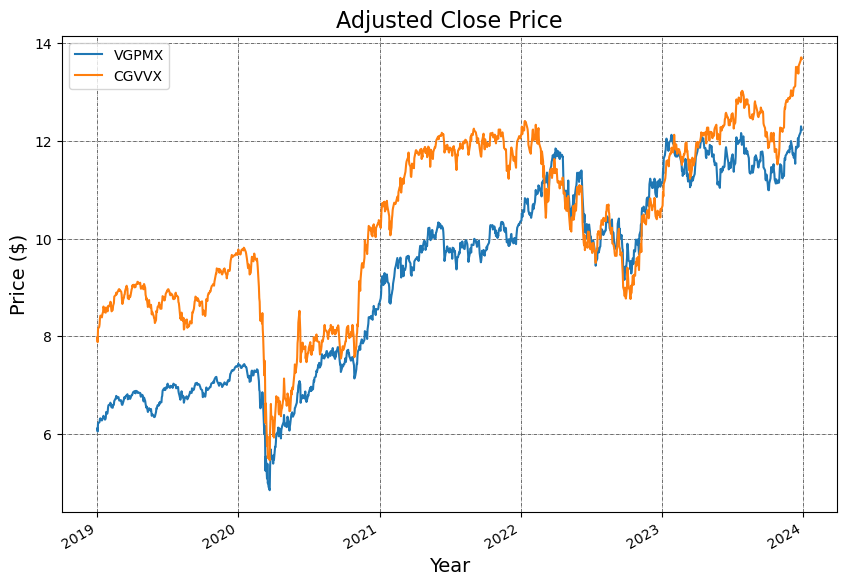

In [10]:
#plot stock close prices for Vanguard and Causeway since SPY has much higher stock price
ticker_data[['VGPMX','CGVVX']].plot(figsize=(10,7))

plt.legend

plt.title('Adjusted Close Price',fontsize = 16)

plt.ylabel('Price ($)',fontsize=14)
plt.xlabel('Year',fontsize=14)

plt.grid(which='major',color='k',linestyle='-.',linewidth=0.4)

plt.show()

In [11]:
#compute the daily and cumulative returns
ticker_daily_returns = ticker_data.pct_change()
ticker_daily_returns = ticker_daily_returns[1:]

ticker_cum_returns = (1 + ticker_daily_returns).cumprod()-1
ticker_cum_returns = ticker_cum_returns.reset_index()

ticker_total_period_return = ticker_cum_returns.iloc[:,1:].tail(1)
ticker_total_period_return = ticker_total_period_return*100
print(ticker_total_period_return)

             SPY      VGPMX      CGVVX
1256  106.156831  99.974272  71.580539


In [14]:
#plotting the cumulative returns for the stocks
ticker_cum_returns_2 = ticker_cum_returns.melt(id_vars=['Date'], var_name='ticker', value_name='cum_return')
ticker_cum_returns_2['cum_pct'] = ticker_cum_returns_2['cum_return']*100

ticker_cum_fig = px.line(ticker_cum_returns_2, x='Date',y='cum_pct',color='ticker',
                        title='Cumulative Stock Daily Returns',labels={'cum_pct':'daily cumulative returns (%)',})
ticker_cum_fig.show()

c:\Users\jonge\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  v = v.dt.to_pydatetime()


In [15]:
#lets look at mean returns and std dev
display(ticker_daily_returns.mean(),ticker_daily_returns.std())

SPY      0.000664
VGPMX    0.000631
CGVVX    0.000543
dtype: float64

SPY      0.013226
VGPMX    0.012579
CGVVX    0.015013
dtype: float64

In [16]:
#one more look at correlation and covariance
display(ticker_daily_returns.corr(),ticker_daily_returns.cov())

,SPY,VGPMX,CGVVX
SPY,1.000000,0.821197,0.863670
VGPMX,0.821197,1.000000,0.846592
CGVVX,0.863670,0.846592,1.000000


,SPY,VGPMX,CGVVX
SPY,0.000175,0.000137,0.000171
VGPMX,0.000137,0.000158,0.000160
CGVVX,0.000171,0.000160,0.000225
